In [740]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import minimize, Bounds, LinearConstraint

In [741]:
df = pd.read_csv('/Users/thomasdeconinck/Downloads/5_Industry_Portfolios.CSV', header=6)

df_5 = df.iloc[1108:1169]

df_5 = df_5.rename(columns={'Unnamed: 0': 'Date'})

df_5['Date'] = pd.to_datetime(df_5['Date'], format='%Y%m')

df_5.set_index('Date', inplace=True)

df_5 =df_5.apply(pd.to_numeric, errors='coerce')

In [742]:
df_10 = df.iloc[1049:1169]
df_10

,Unnamed: 0,Cnsmr,Manuf,HiTec,Hlth,Other
1049,201312,1.12,2.88,3.98,0.62,3.10
1050,201401,-5.95,-4.10,-1.93,1.88,-4.37
1051,201402,4.91,5.10,4.58,6.48,3.49
1052,201403,0.71,1.45,-0.45,-2.56,1.98
1053,201404,0.06,3.04,-0.74,-0.41,-1.97
...,...,...,...,...,...,...
1164,202307,2.36,4.15,4.10,-0.11,5.24
1165,202308,-1.82,-1.82,-1.58,-0.22,-3.35
1166,202309,-4.94,-3.95,-5.82,-4.71,-3.41
1167,202310,-3.43,-3.05,-1.68,-4.58,-2.53


In [743]:
ret = df_5.values / 100
variance = np.var(ret, axis=0, keepdims=True)
std = np.sqrt(np.var(ret, axis=0, keepdims=True))

# Plage des rendements cibles
target_returns = np.linspace(-0.10, 0.10, num=100)  # Génère 100 valeurs entre -10% et 10%

rf = 0.44 / 100

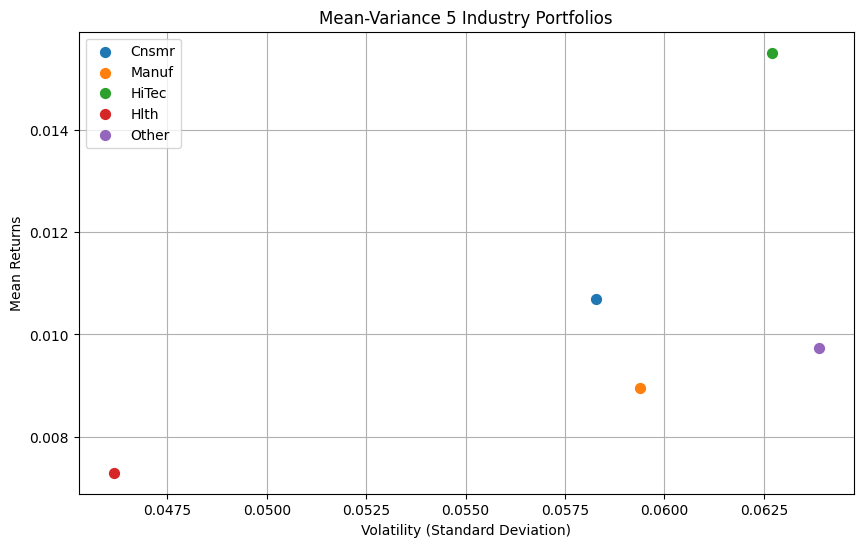

In [744]:
# Names for the 5 portfolios, for labeling purposes
portfolio_names = ['Cnsmr', 'Manuf', 'HiTec', 'Hlth', 'Other']

# Recalculating mean returns and standard deviation using the provided 'ret' data
mean_returns = np.mean(ret, axis=0)
std = np.sqrt(variance[0])

# Plotting the mean-variance locus for the 5 industry portfolios
plt.figure(figsize=(10, 6))

# Scatter plot for each portfolio: x-axis is volatility (std) and y-axis is mean returns
for i, name in enumerate(portfolio_names):
    plt.scatter(std[i], mean_returns[i], label=name, s=50)

plt.title('Mean-Variance 5 Industry Portfolios')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Mean Returns')
plt.legend()

plt.grid(True)
plt.show()


In [745]:
# Définissons la matrice de covariance et le vecteur de rendements moyens
Sigma = np.cov(ret.T)
mean_returns = np.mean(ret, axis=0)

# Définissons les poids des actifs initiaux (équipondérés) pour le portefeuille de minimisation de la variance
initial_weights = np.ones(len(mean_returns)) / len(mean_returns)


### Résolution Analytique du problème de minimisation de la variance du portefeuille 

In [746]:
z_barre = np.mean(ret, axis=0)  
Z_barre = z_barre  # Rendements espérés des actifs
exp_ret = Z_barre
R_cible = 0.10  # Rendement espéré du portefeuille cible
ones = np.ones(len(Z_barre))  # Vecteur de uns

# Inversion de la matrice de covariance
Sigma_inv = np.linalg.inv(Sigma)

# Construction de la matrice A et du vecteur b
A = np.array([
    [np.dot(ones, np.dot(Sigma_inv, ones)), np.dot(ones, np.dot(Sigma_inv, Z_barre))],
    [np.dot(Z_barre, np.dot(Sigma_inv, ones)), np.dot(Z_barre, np.dot(Sigma_inv, Z_barre))]
])
b = np.array([1, R_cible])

# Inversion de la matrice A
A_inv = np.linalg.inv(A)

# Résolution pour obtenir les multiplicateurs de Lagrange
lambda_theta = np.dot(A_inv, b)

# Calcul des poids optimaux du portefeuille
w_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)

print("Lambda (lambda_theta[0]) :", lambda_theta[0])
print("Theta (lambda_theta[1]) :", lambda_theta[1])
print("Poids optimaux du portefeuille :", w_optimal)

Lambda (lambda_theta[0]) : -0.009286631802444512
Theta (lambda_theta[1]) : 1.681232793272242
Poids optimaux du portefeuille : [-9.6382445   1.83034106 15.78561255 -3.96809469 -3.00961443]


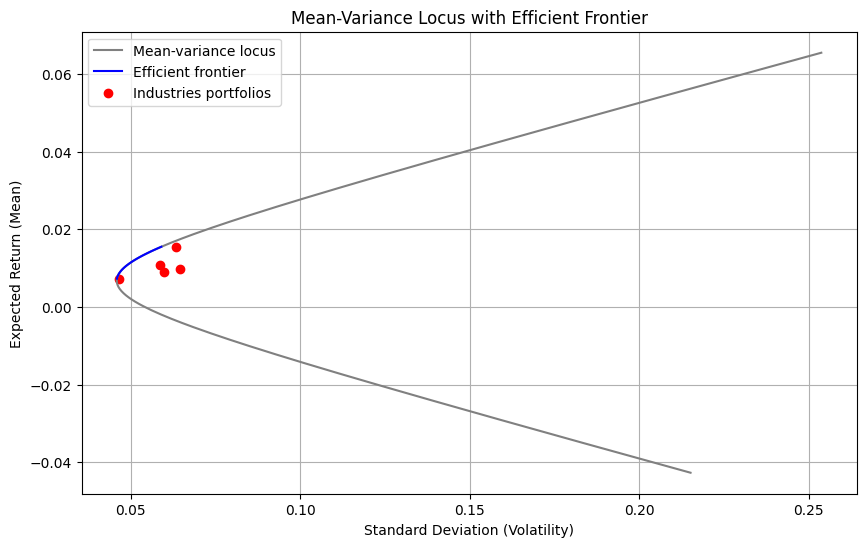

In [747]:
# Intervalle des rendements cibles pour la frontière efficiente
rendements_cibles_efficients = np.linspace(min(Z_barre), max(Z_barre), 100)

# Calcul des volatilités et des rendements pour la frontière efficiente
volatilites_optimales = []
rendements_optimaux = []
for R_cible in rendements_cibles_efficients:
    b = np.array([1, R_cible])
    lambda_theta = np.dot(A_inv, b)
    w_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)
    rendement_optimal = np.dot(w_optimal, Z_barre)
    volatilite_optimale = np.sqrt(np.dot(w_optimal.T, np.dot(Sigma, w_optimal)))
    rendements_optimaux.append(rendement_optimal)
    volatilites_optimales.append(volatilite_optimale)

# Étendre l'intervalle des rendements cibles pour la frontière complète
rendements_cibles_etendus = np.linspace(min(Z_barre) - 0.05, max(Z_barre) + 0.05, 200)

# Calcul des volatilités et des rendements pour la frontière complète
volatilites_optimales_etendues = []
rendements_optimaux_etendus = []
for R_cible in rendements_cibles_etendus:
    b = np.array([1, R_cible])
    lambda_theta = np.dot(A_inv, b)
    w_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)
    rendement_optimal = np.dot(w_optimal, Z_barre)
    volatilite_optimale = np.sqrt(np.dot(w_optimal.T, np.dot(Sigma, w_optimal)))
    rendements_optimaux_etendus.append(rendement_optimal)
    volatilites_optimales_etendues.append(volatilite_optimale)

# Tracer la frontière complète et la frontière efficiente
plt.figure(figsize=(10, 6))
plt.plot(volatilites_optimales_etendues, rendements_optimaux_etendus, label='Mean-variance locus', color='grey')
plt.plot(volatilites_optimales, rendements_optimaux, label='Efficient frontier', color='blue')
plt.scatter(np.sqrt(np.diag(Sigma)), Z_barre, color='red', label='Industries portfolios')
plt.title('Mean-Variance Locus with Efficient Frontier')
plt.xlabel('Standard Deviation (Volatility)')
plt.ylabel('Expected Return (Mean)')
plt.legend()
plt.grid(True)
plt.show()

### Résolution Numérique du problème de minimisation de la variance du portefeuille 

In [748]:
z_barre = np.mean(ret, axis=0)  
Z_barre = z_barre  # Rendements espérés des actifs
Sigma = np.cov(ret.T)
exp_ret = Z_barre
R_cible = 0.10  # Rendement espéré du portefeuille cible
ones = np.ones(len(Z_barre))  # Vecteur de uns

In [749]:
# Fonction objectif : Variance du portefeuille
def portfolio_variance(W, z_barre, Sigma):
    return W.T @ (Sigma @ W)

# Poids initiaux : répartition uniforme
W = np.ones(len(Z_barre)) * (1.0 / len(Z_barre))

# Fonction d'optimisation
def optimize(func, W, z_barre, Sigma, target_return):

    # Contraintes
    opt_constraints = ({'type': 'eq', 'fun': lambda W: ones @ W.T - 1},  # La somme des poids doit être égale à 1
                       {'type': 'eq', 'fun': lambda W: target_return - W.T @ z_barre})  # Le rendement attendu doit être égal au rendement cible

    # Optimisation
    optimal_weights = minimize(func, W, args=(z_barre, Sigma), method='trust-constr', constraints=opt_constraints)

    return optimal_weights.x

# Appel de la fonction d'optimisation
optimal_weights = optimize(portfolio_variance, W, Z_barre, Sigma, R_cible)

print("Poids optimaux du portefeuille :", optimal_weights)

Poids optimaux du portefeuille : [-9.63824634  1.83034021 15.7856131  -3.96809386 -3.00961311]


/Users/thomasdeconinck/anaconda3/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


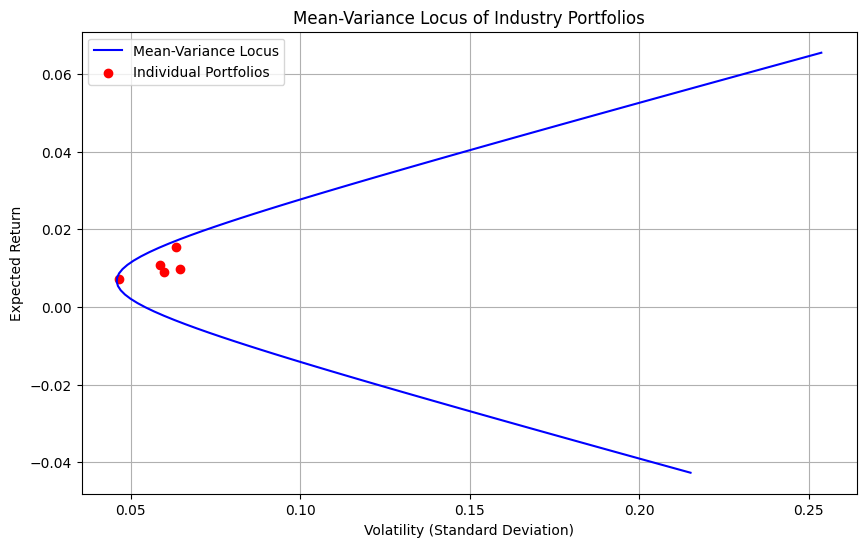

In [750]:
# Générer une série de rendements cibles
rendements_cibles = np.linspace(min(Z_barre) - 0.05, max(Z_barre) + 0.05, 100)

# Initialiser les listes pour stocker les volatilités et rendements optimaux
volatilites_optimales = []
rendements_optimaux = []

# Itérer sur les rendements cibles pour optimiser les poids du portefeuille
for R_cible in rendements_cibles:
    W = np.ones(len(Z_barre)) * (1.0 / len(Z_barre))  # Réinitialiser les poids initiaux pour chaque itération
    poids_optimaux = optimize(portfolio_variance, W, Z_barre, Sigma, R_cible)
    var_optimale = portfolio_variance(poids_optimaux, Z_barre, Sigma)
    rendement_optimal = np.dot(poids_optimaux, Z_barre)

    volatilites_optimales.append(np.sqrt(var_optimale))
    rendements_optimaux.append(rendement_optimal)

# Tracer la frontière de variance moyenne
plt.figure(figsize=(10, 6))
plt.plot(volatilites_optimales, rendements_optimaux, 'b-', label='Mean-Variance Locus')
plt.scatter(np.sqrt(np.diag(Sigma)), Z_barre, color='red', label='Individual Portfolios')
plt.title('Mean-Variance Locus of Industry Portfolios')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()


### Risk Free Asset included

In [751]:
# Le taux sans risque hypothétique pour la période donnée, par exemple la moyenne de la colonne RF de vos données
risk_free_rate = 0.03


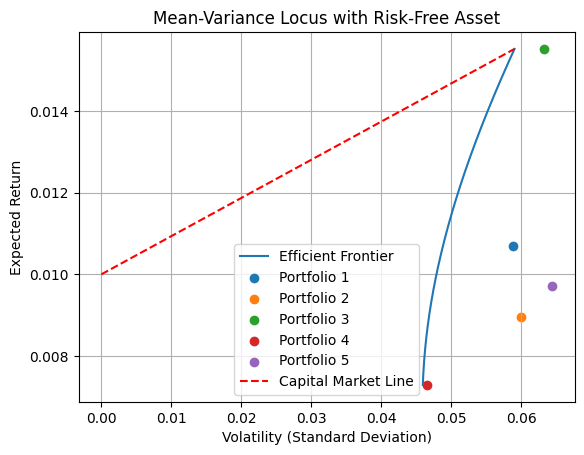

In [752]:
risk_free_rate = 0.01  # Replace with the actual risk-free rate

# Calculate the Sharpe ratio for given weights
def sharpe_ratio(weights, z_barre, Sigma, risk_free_rate):
    portfolio_return = np.dot(weights, z_barre)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
    return (portfolio_return - risk_free_rate) / portfolio_volatility

# Objective function to minimize (negative Sharpe ratio)
def neg_sharpe_ratio(weights, z_barre, Sigma, risk_free_rate):
    return -sharpe_ratio(weights, z_barre, Sigma, risk_free_rate)

# Constraints: Weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},)


# Initial guess for the weights
initial_weights = np.ones(len(z_barre)) / len(z_barre)

# Optimization to find the maximum Sharpe ratio portfolio
result = minimize(neg_sharpe_ratio, initial_weights, args=(z_barre, Sigma, risk_free_rate),
                  method='trust-constr', constraints=constraints)

# Extract the optimal weights
optimal_weights = result.x

# Calculate points for the efficient frontier
target_returns = np.linspace(min(z_barre), max(z_barre), 200)
efficient_volatilities = []
efficient_returns = []

for target_return in target_returns:
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: target_return - np.dot(x, z_barre)})
    
    result = minimize(portfolio_variance, initial_weights, args=(z_barre, Sigma),
                      method='trust-constr', constraints=constraints)
    
    if result.success:
        efficient_volatilities.append(np.sqrt(result.fun))
        efficient_returns.append(target_return)

# Plotting the efficient frontier
plt.plot(efficient_volatilities, efficient_returns, label='Efficient Frontier')

# Plotting the individual portfolios
for i in range(len(z_barre)):
    plt.scatter(np.sqrt(Sigma[i,i]), z_barre[i], label=f'Portfolio {i+1}')

# Plotting the Capital Market Line
cml_x = [0, max(efficient_volatilities)]
cml_y = [risk_free_rate, risk_free_rate + max(efficient_volatilities) * (efficient_returns[np.argmax(efficient_volatilities)] - risk_free_rate) / max(efficient_volatilities)]
plt.plot(cml_x, cml_y, color='red', label='Capital Market Line', linestyle='--')

plt.title('Mean-Variance Locus with Risk-Free Asset')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()

In [753]:
import cvxpy as cp
import numpy as np

In [754]:
N = 5  # Nombre total d'actifs
min_num_assets = 3
max_num_assets = 3
min_weight = 0.05  # Poids minimum de 5%
target_return = 0.10  

In [755]:
# Variables de décision
weights = cp.Variable(N)  # Poids des actifs dans le portefeuille
selection = cp.Variable(N, boolean=True)  # Variables binaires pour la contrainte de cardinalité

# Fonction objectif
risk = cp.quad_form(weights, Sigma)  # Variance du portefeuille (risque)
objective = cp.Minimize(risk)

# Contraintes
constraints = [
    cp.sum(weights) == 1,  # La somme des poids doit être égale à 1
    weights >= min_weight * selection,  # Poids minimum pour les actifs sélectionnés
    cp.sum(selection) <= max_num_assets,  # Cardinalité: au maximum 3 actifs dans le portefeuille
  
]

# Résolution du problème
prob = cp.Problem(objective, constraints)
prob.solve()  # Utilisez un solveur capable de gérer les variables binaires

# Vérifier si le problème a été résolu correctement
if prob.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
    optimal_weights = weights.value
    print("Poids optimaux du portefeuille :", optimal_weights)
else:
    print("Le problème n'a pas de solution optimale ou est inf")

Poids optimaux du portefeuille : [7.50232560e-02 4.13337327e-02 2.95136185e-08 8.83642763e-01
 2.18465550e-07]


### trouver pourquoi on pas des valeurs de 0 exactement pour les actifs qui ne sont pas inclus dans le portefeuille sous contrainte de cardinalité ?